#                                 SEGMENTATION OF THE PCOS SCANNED IMAGES

---



In [1]:
#IMPORTING NECESSARY LIBRARIES
"""COMPUTER VISION FOR HANDLING IMAGES"""
import cv2
"""The OS module in Python provides functions for interacting with the operating system."""
import os
"""to connect our google drive"""  
from google.colab import drive
drive.mount('/content/drive')
""" for Preprocessing data with TensorFlow Transform"""
import tensorflow as tf
"""TO deal with neural network"""                                   
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

Mounted at /content/drive


## BUILDING AN UNET MODEL

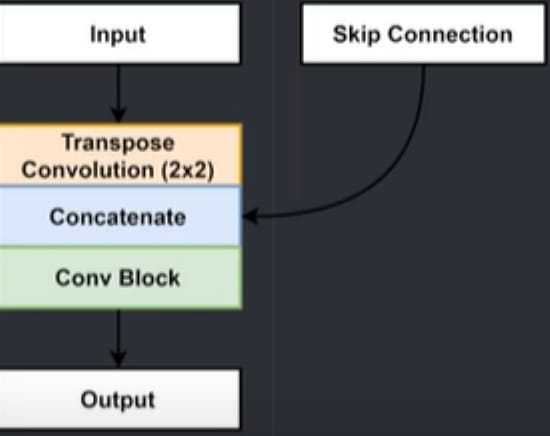

In [2]:
# first  building an convolution block followed by batch normalization and relu activation
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [3]:
# an encoder block followed by convolution block and  2*2 maxpooling block
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [4]:
# an decoder block followed by convolution2D transpose block 
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
# here concatenate the output of encoderblock after conv2Dtranspose and skip_features
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

## UNET ARCHITECTURE




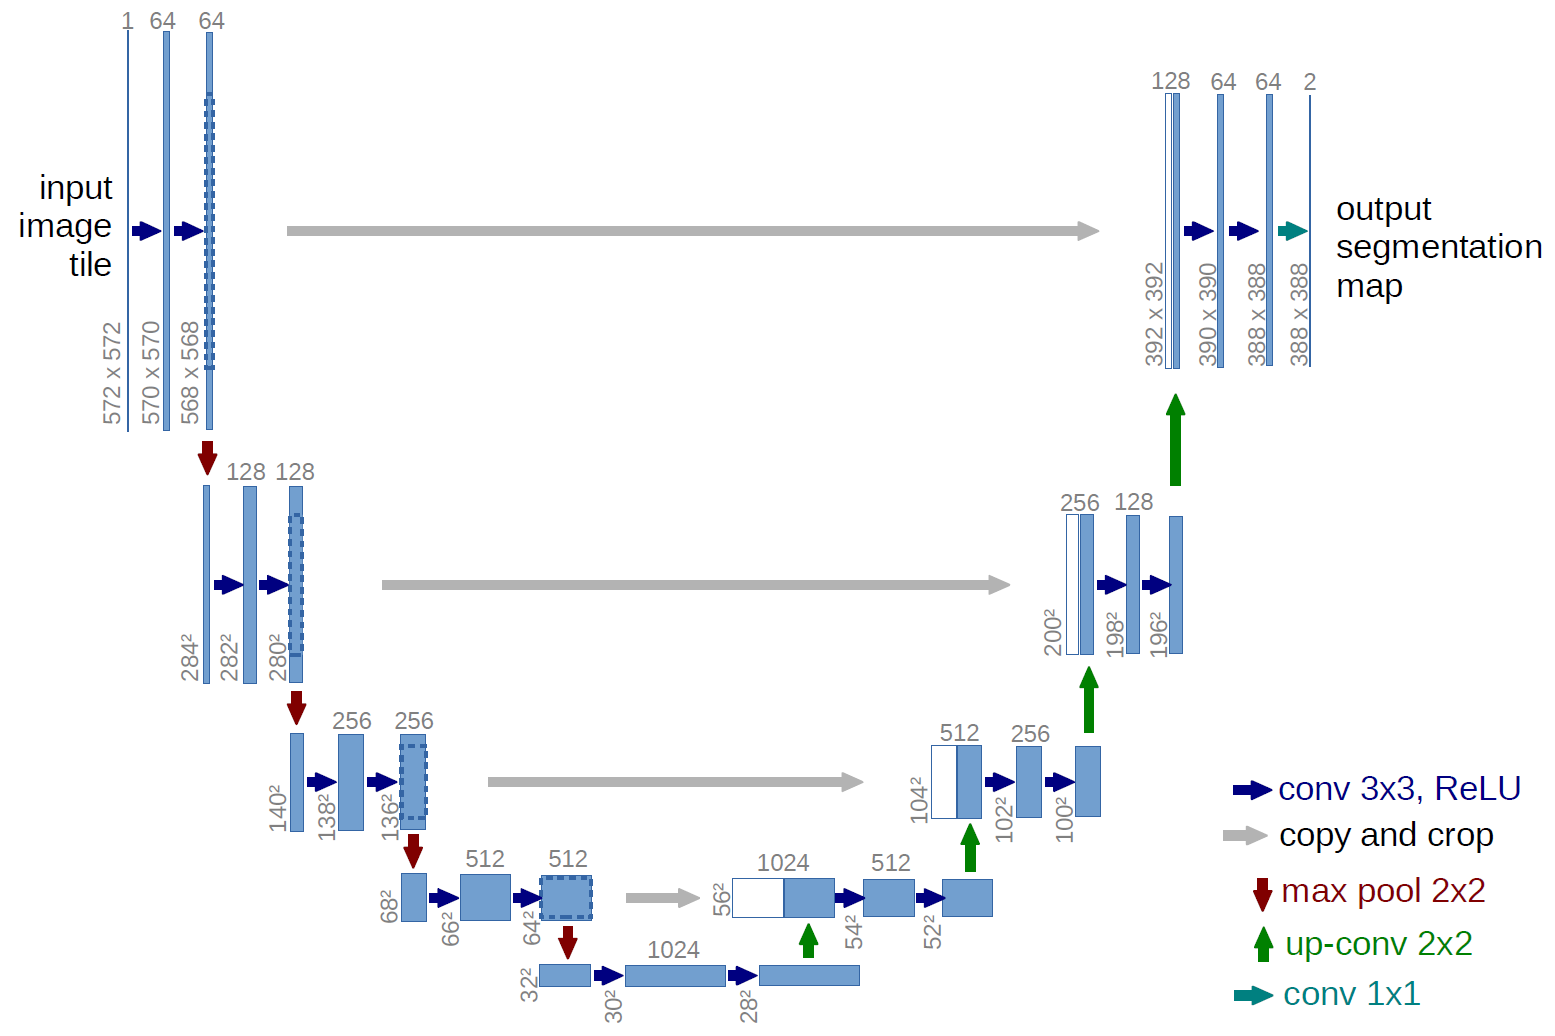

In [5]:
def build_unet(input_shape):
  # INPUT LAYER TAKES INPUT SHAPE
    inputs = Input(input_shape)
# FOUR ENCODER BLOCK WHERE S =SKIP CONNECTION AND P=POOLING 
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
# A BRIDGE FOR ENCODER AND DECODER BLOCK
    b1 = conv_block(p4, 1024)
# FOUR DECODER BLOCK  WHERE HEIGHT AND WIDTH INCREASED BY STRIDE VALUE OF 2
    d1 = decoder_block(b1, s4, 512) 
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
# OUTPUT BLOCK WHERE THE ACTIVATION IS SIGMOID BECAUSE 1 REFERS TO THE MASK PART AND 0 REFERS TO THE BACKGROUND PART
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
# GIVING THE OUTPUT AND INPUT TO THE UNET MODEL
    model = Model(inputs, outputs, name="U-Net")
    return model

In [6]:
if __name__ == "__main__":
  # GET THE INPUT SHAPE
    input_shape = (512, 512, 3)
    # BUILD THE UNET MODEL USING THE INPUT SHAPE
    model = build_unet(input_shape)
    # GETTING THE SUMMARY OF THE MODEL
    model.summary()


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

METRICS FOR THE UNET MODEL

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [8]:
import os
# TO AVOID THE TENSOR FLOW MESSAGE
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# IT IS JUST TO EXTRACT THE IMAGE PATH
from glob import glob
# SPLITTING THE DATA USING SKLEARN
from sklearn.model_selection import train_test_split
import tensorflow as tf
"""1.MODELCHECKPOINT TO SAVE THE MODEL WEIGHTS
   2.CSVLOGGER IS TO SAVE THE TRAINING AND VALIDATION METRICES AS A CSV FILE
   3.TO REDUCE THE LEARNING RATE WHEN THE TRAINING STOPS IMPROVING"""
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
# TO IMPORT THE ADAM OPTIMIZERS
from tensorflow.keras.optimizers import Adam
# IMPORT KERAS MODULE FROM TENSORFLOW
from tensorflow import keras
from keras import Model
from keras.models import Model
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.python.keras import models

In [9]:
""" Global parameters HEIGHT AND WIDTH """
H = 512
W = 512

In [10]:
def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)

In [11]:
# LOADING AND SPLITTING THE DATA
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "/content/drive/MyDrive/mask/pcos scan", "*.jpg")))
    masks1 = sorted(glob(os.path.join(path, "/content/drive/MyDrive/mask/mask", "*.jpg")))
    train_x, test_x = train_test_split(images, test_size=1, random_state=42)
    train_y1, test_y1 = train_test_split(masks1, test_size=1, random_state=42)
    return (train_x, train_y1), (test_x, test_y1)

In [12]:
# READING THE USD IMAGE
def read_image(path):
    """CONVERTING INTO 3 CHANNEL IMAGE"""
    x = cv2.imread(path, cv2.IMREAD_COLOR)  
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

In [13]:
# READING THE CORRESPONDING USD MASK IMAGE
def read_mask(path1):
    x1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
    x = x1
    x = cv2.resize(x, (W, H))
    x = x/np.max(x)
    """USING THRESHOLD TO CONVERT IT INTO  PROPER 0 OR 1"""
    x = x > 0.5      
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

In [14]:
# TAKE A SINGLE IMAGE PATH
def tf_parse(x, y1):
    def _parse(x, y1):
        """DECODE IS TO CONVERT IT INTO STRINGS"""
        x = x.decode() 
        y1 = y1.decode()
        
# READING IMAGE AND MASK TO GET THE ARRAY
        x = read_image(x)   
        y = read_mask(y1)
        return x, y
# RETURN X AND Y IN THE FORM OF TENSORS
    x, y = tf.numpy_function(_parse, [x, y1], [tf.float32,tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y


In [15]:
# THIS IS TO MAKE THE PROCESS FAST"""
def tf_dataset(X, Y1, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y1))   
    """SHUFFLE THE DATA"""
    dataset = dataset.shuffle(buffer_size=20)  

    dataset = dataset.map(tf_parse)   

    """TAKE A BATCH OF DATA"""        
    dataset = dataset.batch(batch)
    
    """PREFETCHING THE DATA IN ADVANCE TO STORE IT IN RAM"""
    dataset = dataset.prefetch(1)
    print(dataset)
    return dataset

In [16]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 2
    lr = 1e-5
    # num_epochs = 10
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "data.csv")

    """ Dataset """
    dataset_path = "/content/drive/MyDrive/mask"
    (train_x, train_y1),(test_x, test_y1) = load_data(dataset_path)

    print(f"Train: {len(train_x)} - {len(train_y1)}")
    print(f"Test: {len(test_x)} - {len(test_y1)} ")

Train: 5 - 5
Test: 1 - 1 


In [17]:
# dividing training and testing dataset


train_dataset = tf_dataset(train_x,train_y1,batch=batch_size)
test_dataset = tf_dataset(test_x, test_y1, batch=batch_size)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None))>


In [18]:
# PRINTING THE SHAPE OF TRAIN DATA
for x,y in train_dataset:
    print(x.shape)
    print(y.shape)

(2, 512, 512, 3)
(2, 512, 512, 1)
(2, 512, 512, 3)
(2, 512, 512, 1)
(1, 512, 512, 3)
(1, 512, 512, 1)


In [19]:
# PRINTING THE SHAPE OF TEST DATA
for x,y in test_dataset:
    print(x.shape)
    print(y.shape)

(1, 512, 512, 3)
(1, 512, 512, 1)


**MODEL ** 

In [20]:
model = build_unet((H, W, 3))
metrics = [dice_coef, iou, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

In [21]:
callbacks = [ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path)]

In [22]:
model.fit(train_dataset,
        epochs=2,
        callbacks=callbacks)

Epoch 1/2
3/3 [==============================] - 138s 39s/step - loss: 0.6438 - dice_coef: 0.3977 - iou: 0.2681 - recall: 0.3458 - precision: 0.3932 - lr: 1.0000e-05
Epoch 2/2
3/3 [==============================] - 130s 39s/step - loss: 0.6368 - dice_coef: 0.4043 - iou: 0.2727 - recall: 0.3667 - precision: 0.4043 - lr: 1.0000e-05


In [23]:
# SAVING THE MODEL
model.save("sowmi.model")

INFO:tensorflow:Assets written to: sowmi.model/assets


EVALUTION

In [24]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from google.colab.patches import cv2_imshow

In [25]:
# INITIALIZING THE HEIGHT AND WEIGHT
H = 512
W = 512


100%|██████████| 1/1 [00:07<00:00,  7.54s/it]


 ORIGINAL SCAN IMAGE


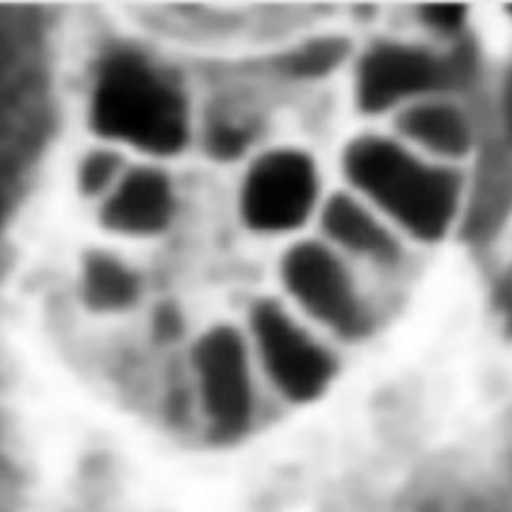

ORIGINAL GROUND TRUTH


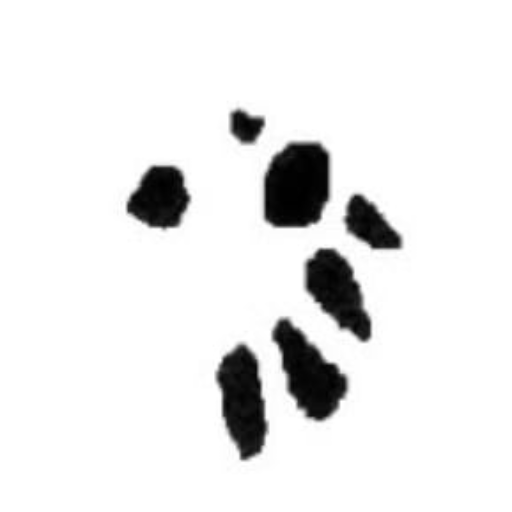

PREDICTED GROUND TRUTH


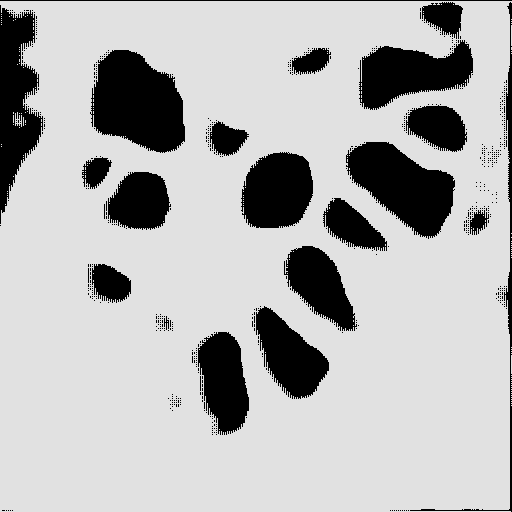

In [29]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("results")

    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("sowmi.model")

    """ Dataset """
    dataset_path = "/content/drive/MyDrive/mask"
    (train_x, train_y1), (test_x, test_y1) = load_data(dataset_path)

    """ Predicting the mask """
    # TQDM-PROGRESS BAR
    for x, y1 in tqdm(zip(test_x, test_y1), total=len(test_x)):
        """ Extracing the image name. """
        image_name = x.split("/")[-1]

        """ Reading the image """
        ori_x = cv2.imread(x, cv2.IMREAD_COLOR)
        ori_x = cv2.resize(ori_x, (W, H))
        x = ori_x/255.0
        x = x.astype(np.float32)
        x = np.expand_dims(x, axis=0)

        """ Reading the mask """
        ori_y1 = cv2.imread(y1, cv2.IMREAD_GRAYSCALE)
        ori_y = ori_y1
        ori_y = cv2.resize(ori_y, (W, H))
        ori_y = np.expand_dims(ori_y, axis=-1)  ## (512, 512, 1)
        ori_y = np.concatenate([ori_y, ori_y,ori_y], axis=-1)  ## (512, 512, 3)

        """ Predicting the mask. """
        y_pred = model.predict(x)[0] > 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the predicted mask along with the image and GT """
        save_image_path = f"results/{image_name}"
        y_pred = np.concatenate([y_pred, y_pred,y_pred], axis=-1)

        sep_line = np.ones((H, 10,3)) * 255

        cat_image = np.concatenate([ori_x, sep_line, ori_y, sep_line, y_pred*255],axis=1)
        
        cv2.imwrite(save_image_path, cat_image)
print("\n ORIGINAL SCAN IMAGE")
cv2_imshow(ori_x)
print("ORIGINAL GROUND TRUTH")
cv2_imshow(ori_y)
print("PREDICTED GROUND TRUTH")
cv2_imshow(y_pred*225)



### **FINAL PREDICTION THAT IS STORE IN A DIRECTORY**

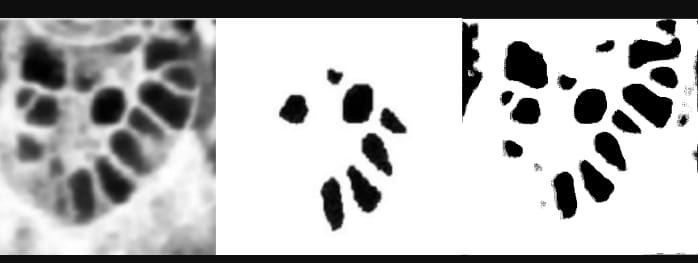